# **TEMPERATURE FORECAST**

## Initialize

In [1]:
import os
import io
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, GlobalAveragePooling1D, Bidirectional, LSTM, Conv1D, MaxPooling1D, Dropout, Lambda
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, LearningRateScheduler

In [2]:
# set random seeds
np.random.seed(51)
tf.random.set_seed(51)

# show figures inline
%matplotlib inline

# ignore all warning (NOT recommended)
warnings.filterwarnings("ignore")

## Dataset

**Get the dataset**

In [3]:
data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
path_out = '../.tmp/daily-min-temperatures.csv'

# download the dataset
if not os.path.exists(path_out):
    os.system(f"""wget --no-check-certificate {data_url} -O {path_out}""")

# read the csv file
df = pd.read_csv(path_out)

df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


**Extract the data**

series shape: (3650, 1)


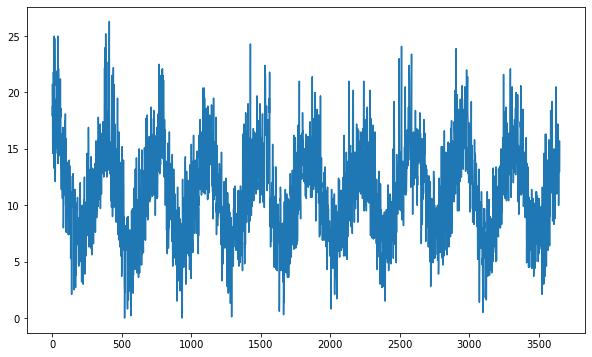

In [4]:
# temperature time series
series = df['Temp'].to_numpy()
# expand dims for using conv layer
series = np.expand_dims(series, axis=-1)
print(f'series shape: {series.shape}')

time = np.arange(len(series))

# show the series in a graph
plt.figure(figsize=(10, 6))
plt.plot(time, series)
plt.show()

**Split the dataset**

In [5]:
# time point to split train and validation data
split_time = 2500

# training data
t_train = time[:split_time]    # time
x_train = series[:split_time]  # values

# validation data
t_valid = time[split_time:]    # time
x_valid = series[split_time:]  # values

# check dataset sizes
print(f'size - training: {len(x_train)}, validation: {len(x_valid)}')

size - training: 2500, validation: 1150


**Windowed Dataset**

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer=None, shuffle=True):
    # convert to tfds
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # from the time-series data, iteratively extract data in rolling windows
    # window size = window_size (features) + 1 (label)
    # rolling window shifts 1 time step (shift=1)
    # if the window does not have enough data points, drop it (drop_remainder=True)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)

    # flat the window into chunks
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # shuffle the dataset
    # using 'shuffle_buffer' speeds up shuffling for large dataset
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer)

    # split features (all but the last data point) and labels (the last one)
    # iteratively return those as tuples
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # iteratively return data in a batch
    dataset = dataset.batch(batch_size).prefetch(1)

    return  dataset

# inputs
window_size = 60
batch_size = 100
shuffle_buffer_size = 1000

# create windowed dataset
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Evaluation Metrics

**Mean squarred error (MSE)**
- Use when large error is significantly more critical.

**Mean absolute error (MAE)**
- Use when errors are proportionally critical.

In [7]:
# function for calculating MSE
MSE = lambda actual, prediction: np.mean((actual - prediction)**2)
# function for calculating MAE
MAE = lambda actual, prediction: np.mean(abs(actual - prediction))

## Model

In [8]:
def build_model():
    # input layer
    input_tensor = Input(shape=[window_size, 1])
    
    # conv layer
    x = Conv1D(filters=60, kernel_size=5, strides=1, padding="causal", activation="relu")(input_tensor)

    # LSTM layers
    x = Bidirectional(LSTM(60, return_sequences=True))(x)
    x = Bidirectional(LSTM(60, return_sequences=True))(x)

    # dense layers
    x = Dense(30, activation='relu')(x)
    x = Dense(10, activation='relu')(x)

    # output layer
    x = Dense(1)(x)
    # scale up the output
    output_tensor = Lambda(lambda x: x * 400.)(x)

    # model
    model = tf.keras.Model(input_tensor, output_tensor)

    return model

# clear session
tf.keras.backend.clear_session()

# set random seeds
np.random.seed(51)
tf.random.set_seed(51)

# create a model
model = build_model()

# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 60)            360       
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 120)           58080     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 120)           86880     
_________________________________________________________________
dense (Dense)                (None, 60, 30)            3630      
_________________________________________________________________
dense_1 (Dense)              (None, 60, 10)            310       
_________________________________________________________________
dense_2 (Dense)              (None, 60, 1)             11    

## Hyper-parameter Tuning

**Get an optimal learning rate**

In [9]:
# callback for learning rate scheduling
# schedule a learning rate for exponential increase
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))

# compile
model.compile(
    optimizer=SGD(lr=1e-8, momentum=0.9),
    loss=tf.keras.losses.Huber(),
    metrics=['mae']
)

# train for 100 epochs
hist = model.fit(
    dataset,
    epochs=100,
    callbacks=[lr_schedule],
    verbose = 0
)

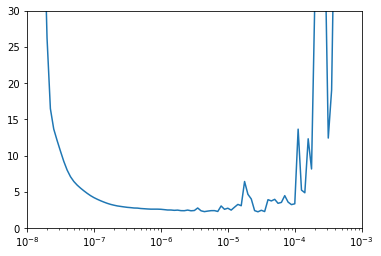

the learning rate with the minimum loss: 2.818382931264455e-05


In [10]:
# learning rates
lrs = 1e-8 * 10 ** (np.arange(100) / 20)

# plot the learning rate vs. loss (MSE) graph
plt.figure()
plt.semilogx(lrs, hist.history['loss'])
plt.axis([1e-8, 1e-3, 0, 30])
plt.show()

# the learning rate with the minimum loss
idx = np.argmin(hist.history['loss'])
print('the learning rate with the minimum loss:', lrs[idx])

## Train

In [11]:
class SimpleVerbose(tf.keras.callbacks.Callback):
    """
    prints loss and metrics at certain frequency.
    """
    def __init__(self, freq=10, items=None):
        super(SimpleVerbose, self).__init__()
        self.freq = freq
        self.items = items
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 0:
            print('Training started ...')
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % self.freq == 0:
            print(f"Epoch {epoch+1} ", end='')
            for item in self.items:
                print(f"- {item}: {logs.get(item):.4f} ", end='')
            print()

simple_verbose = SimpleVerbose(freq=10, items=['loss', 'mae'])

In [12]:
# clear session
tf.keras.backend.clear_session()

# set random seeds
np.random.seed(51)
tf.random.set_seed(51)

# create a new model
model = build_model()

# compile
model.compile(
    optimizer=SGD(lr=1e-5, momentum=0.9),
    loss=tf.keras.losses.Huber(),
    metrics=['mae']
)

# train for 150 epochs
hist = model.fit(
    dataset,
    epochs=150,
    verbose = 0,
    callbacks=[simple_verbose]
)

Training started ...
Epoch 10 - loss: 2.0610 - mae: 2.5173 
Epoch 20 - loss: 1.9658 - mae: 2.4206 
Epoch 30 - loss: 2.4711 - mae: 2.9339 
Epoch 40 - loss: 1.9699 - mae: 2.4244 
Epoch 50 - loss: 1.8257 - mae: 2.2772 
Epoch 60 - loss: 1.9253 - mae: 2.3792 
Epoch 70 - loss: 1.8720 - mae: 2.3251 
Epoch 80 - loss: 1.8560 - mae: 2.3090 
Epoch 90 - loss: 2.0084 - mae: 2.4650 
Epoch 100 - loss: 1.8730 - mae: 2.3271 
Epoch 110 - loss: 1.9040 - mae: 2.3577 
Epoch 120 - loss: 1.9337 - mae: 2.3885 
Epoch 130 - loss: 1.7281 - mae: 2.1783 
Epoch 140 - loss: 1.7463 - mae: 2.1990 
Epoch 150 - loss: 1.8708 - mae: 2.3247 


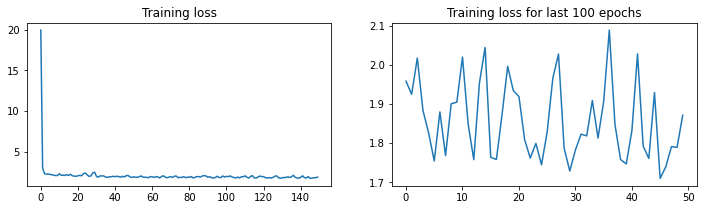

In [13]:
# plot the loss graph
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.title('Training loss')
plt.plot(hist.history['loss'])

plt.subplot(1, 2, 2)
plt.title('Training loss for last 100 epochs')
plt.plot(hist.history['loss'][-50:])

plt.show()

## Test
**One way**

In [14]:
# generate inputs from validation data
inputs = []
for time in range(split_time-window_size, len(series) - window_size):
    inputs.append(series[time:time + window_size])

# get predictions
forecast = model.predict(np.array(inputs))[:, 0]

# evaluation metrics
print(f'MSE: {MSE(x_valid, forecast):.6f}')
print(f'MAE: {MAE(x_valid, forecast):.6f}')

MSE: 11.289394
MAE: 2.679747


**Another way**

In [15]:
# get total dataset
total_dataset = windowed_dataset(series, window_size, batch_size, shuffle=False)

# get predictions
forecast = model.predict(total_dataset)[split_time - window_size:, 0]

# evaluation metrics
print(f'MSE: {MSE(x_valid, forecast):.6f}')
print(f'MAE: {MAE(x_valid, forecast):.6f}')

MSE: 11.289394
MAE: 2.679747


**Plot graph**

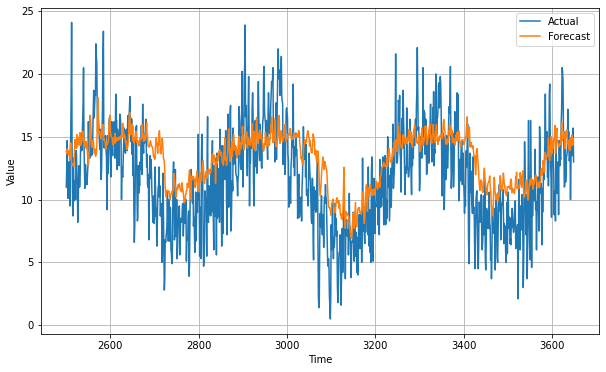

In [16]:
# compare in graph
plt.figure(figsize=(10, 6))

plt.plot(t_valid, x_valid, label='Actual')
plt.plot(t_valid, forecast, label='Forecast')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)

plt.show()